In [1]:
import h5py, sys, os
import numpy as np
from scipy.special import j1
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from pyhank import HankelTransform
print(os.getcwd())

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

print(base_dir)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves
/store/ATMOS/cwp29/data/waves/final/N_1/


In [2]:
def amplitudes(var, rs, tstart, tend, z):
    tstart_idx = get_index(tstart, times)
    tend_idx = get_index(tend, times)
    
    waves = var[tstart_idx:1+tend_idx, get_index(z, gzf), :]
    
    H = HankelTransform(order=0, radial_grid = rs)

    wavesH = np.zeros_like(waves)

    for i in range(tend_idx-tstart_idx+1):
        wavesH[i] = H.qdht(waves[i])

    return np.fft.rfft(wavesH, axis=0)

Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nlwf_xz', 'nlwf_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'tked_xy', 'tked_xz', 'tked_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>
Az keys: <KeysViewHDF5 ['b_az', 'bb_sfluc', 'p_az', 'th_az', 'u_az', 'ub_sfluc', 'uth_sfluc', 'uu_sfluc', 'uv_sfluc', 'uw_sfluc', 'v_az', 'vv_sfluc', 'vw_sfluc', 'w_az', 'wb_sfluc', 'ww_sfluc']>
Plume penetration occured at t=2.6185
3.12
50.525999999999996 12.6
Time range: 12.56 to 50.37 s
equal to 6.00 buoyancy periods


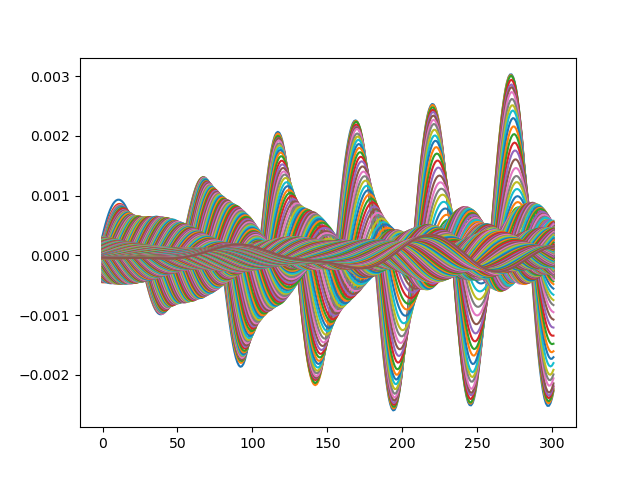

(312, 257, 256)
(312, 257, 256)
(302, 256)


In [3]:
#Load simulation data
_, times = load_data('th1_xz')
var1, var2 = load_az_data('w_az', 'b_az')
NSAMP = len(times)

times, t0_idx = calibrate_time(save_dir, times)

var2 = np.gradient(var2, gzf, axis=1)
var2 = np.gradient(var2, times, axis=0)

print(version)
if version == "3.12":
    buoy_per = round(2*np.pi/np.sqrt(md['N2']),1)
    md['TIME_LIMIT'] = (md['FINE_RES_TIME'] + md['NBUOY_PERIODS'])*buoy_per
    md['SAVE_STATS_DT'] *= buoy_per
    md['SAVE_STATS_DT_FINE'] *= buoy_per
    tend_idx = len(times)-1
    tstart_idx = get_index(md['FINE_RES_TIME']*buoy_per, times)
    print(md['TIME_LIMIT'], md['FINE_RES_TIME']*buoy_per)
    print("Time range: {0:.2f} to {1:.2f} s".format(times[tstart_idx], times[tend_idx]))
    print("equal to {0:.2f} buoyancy periods".format((times[tend_idx]-times[tstart_idx])/buoy_per))
else:
    tstart_idx = get_index(5, times)
    tend_idx = get_index(25, times)
    
zplot = 0.4

#waves = var2[tstart_idx:tend_idx+1, get_index(zplot, gzf), :]
waves = var1[tstart_idx:tend_idx+1, get_index(zplot, gzf), :]

plt.figure()
plt.plot(waves)
plt.show()

print(var1.shape)
print(var2.shape)
print(waves.shape)


In [4]:
print(md)

{'LX': 1.0, 'LY': 1.0, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 1.575, 'NU_START': 1e-09, 'SAVE_FLOW_DT': 50.0, 'VERSION': 3.12, 'NU_START_TIME': 10.0, 'SAVE_STATS_DT_FINE': 0.126, 'FINE_RES_TIME': 2.0, 'TIME_LIMIT': 50.525999999999996, 'NBUOY_PERIODS': 6.02, 'r0': 0.005, 'alpha_e': 0.1, 'b0': 0.2, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.1, 'N2': 1.0, 'H': 0.2, 'b_factor': 0.4, 'Nb': 256.0, 'Nphi': 256.0, 'F_TYPE': 3.0, 'Nx': 512, 'Ny': 512, 'Nz': 257, 'Nth': 2}


In [5]:
dr = md['LX']/md['Nx']
nbins = int(md['Nx']/2)
r_bins = np.array([r*dr for r in range(0, nbins+1)])
r_points = np.array([0.5*(r_bins[i]+r_bins[i+1]) for i in range(nbins)])

print("Total time steps: %s"%NSAMP)
print("Dimensional times: ",times)


Total time steps: 312
Dimensional times:  [-2.61851627 -1.04851627  0.          1.57        3.14        4.71
  6.28        7.85        9.42       10.99       12.56       12.6856
 12.8112     12.9368     13.0624     13.188      13.3136     13.4392
 13.5648     13.6904     13.816      13.9416     14.0672     14.1928
 14.3184     14.444      14.5696     14.6952     14.8208     14.9464
 15.072      15.1976     15.3232     15.4488     15.5744     15.7
 15.8256     15.9512     16.0768     16.2024     16.328      16.4536
 16.5792     16.7048     16.8304     16.956      17.0816     17.2072
 17.3328     17.4584     17.584      17.7096     17.8352     17.9608
 18.0864     18.212      18.3376     18.4632     18.5888     18.7144
 18.84       18.9656     19.0912     19.2168     19.3424     19.468
 19.5936     19.7192     19.8448     19.9704     20.096      20.2216
 20.3472     20.4728     20.5984     20.724      20.8496     20.9752
 21.1008     21.2264     21.352      21.4776     21.6032     21.728

(152, 256)


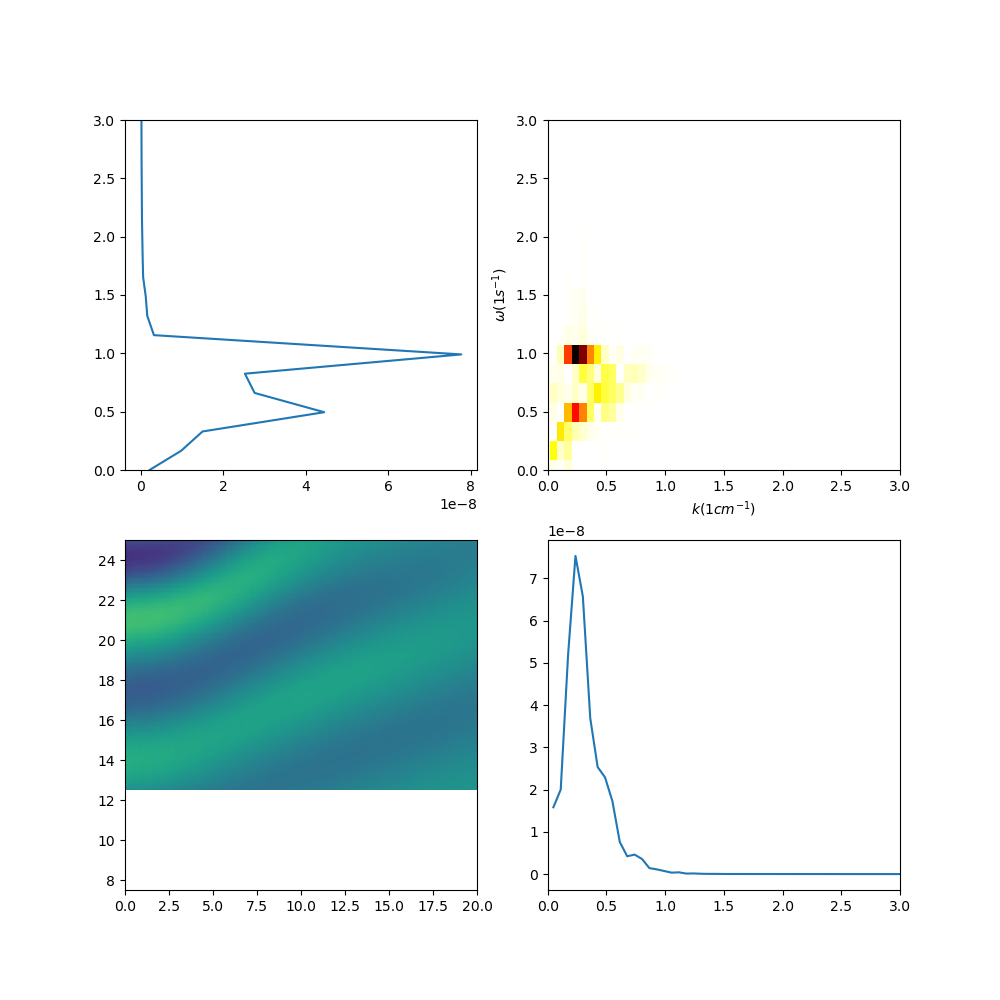

In [6]:
H = HankelTransform(order=0, radial_grid = r_points)

wavesH = np.zeros_like(waves)

for i in range(tend_idx-tstart_idx+1):
    wavesH[i] = H.qdht(waves[i])

amplitudes_nm = np.fft.rfft(wavesH, axis=0)

wavenumber_n = H.kr
freq_m = np.fft.rfftfreq(tend_idx-tstart_idx+1)*2*np.pi/md['SAVE_STATS_DT_FINE']

print(amplitudes_nm.shape)
#print(wavenumber_n)
#print(freq_m)

power = np.power(np.abs(amplitudes_nm), 2)

X, Y = np.meshgrid(wavenumber_n/100, freq_m)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,1].pcolormesh(X, Y, power, cmap='hot_r')
ax[0,1].set_xlabel(r"$k (1 cm^{-1})$")
ax[0,1].set_ylabel(r"$\omega (1 s^{-1})$")
ax[0,1].set_xlim(0, 3)
ax[0,1].set_ylim(0, 3)

times_trunc = times[tstart_idx:tend_idx+1]
X, Y = np.meshgrid(r_points * 100, times_trunc)
ax[1,0].pcolormesh(X, Y, waves)
ax[1,0].set_xlim(0, 20)
ax[1,0].set_ylim(7.5, 25)

ax[0,0].plot(np.mean(power, axis=1), freq_m)
ax[0,0].set_ylim(0, 3)

ax[1,1].plot(wavenumber_n/100, np.mean(power, axis=0))
ax[1,1].set_xlim(0, 3)
plt.show()

In [7]:
##### Calculate vertical energy flux F_wave #####
R = np.max(r_points) # m
N = np.sqrt(md['N2']) # s^-1
rho_0 = 997 #kg per m^3

print(freq_m)
F_wave = 0
theta_m = np.arccos(freq_m/N)
for i in range(len(freq_m)):
    for j in range(len(wavenumber_n)):
        if 0 < freq_m[i] <= N:
            #k_z = np.sqrt(np.power(wavenumber_n[j],2)*(N*N/(freq_m[i]*freq_m[i])-1))
            F_wave += np.cos(theta_m[i]) * np.sin(2*theta_m[i]) * np.power(j1(wavenumber_n[j]*R),2) * \
                    np.power(np.abs(-amplitudes_nm[i,j]/(1j*freq_m[i])),2)/wavenumber_n[j]
                    #np.power(np.abs(-amplitudes_nm[i,j]/(k_z*N*N*freq_m[i])),2)/wavenumber_n[j]
        if np.isnan(F_wave):
            print(theta_m[i], wavenumber_n[j], amplitudes_nm[i,j])
            print(freq_m[i]/N)
            break
    if np.isnan(F_wave):
        break
        
        
F_wave *= 0.25*np.pi*np.power(R,2) * np.power(N,3)*rho_0
F_wave /= 1e-7
print(F_wave) # in erg s^-1

[ 0.          0.16512103  0.33024205  0.49536308  0.66048411  0.82560513
  0.99072616  1.15584719  1.32096821  1.48608924  1.65121027  1.81633129
  1.98145232  2.14657335  2.31169437  2.4768154   2.64193643  2.80705745
  2.97217848  3.13729951  3.30242053  3.46754156  3.63266259  3.79778361
  3.96290464  4.12802567  4.29314669  4.45826772  4.62338875  4.78850977
  4.9536308   5.11875183  5.28387285  5.44899388  5.61411491  5.77923593
  5.94435696  6.10947799  6.27459901  6.43972004  6.60484107  6.76996209
  6.93508312  7.10020415  7.26532517  7.4304462   7.59556723  7.76068825
  7.92580928  8.09093031  8.25605133  8.42117236  8.58629339  8.75141441
  8.91653544  9.08165647  9.24677749  9.41189852  9.57701955  9.74214057
  9.9072616  10.07238263 10.23750365 10.40262468 10.56774571 10.73286673
 10.89798776 11.06310879 11.22822981 11.39335084 11.55847187 11.72359289
 11.88871392 12.05383495 12.21895597 12.384077   12.54919803 12.71431905
 12.87944008 13.04456111 13.20968213 13.37480316 13

/tmp/ipykernel_888636/1633408825.py:8: RuntimeWarning: invalid value encountered in arccos
  theta_m = np.arccos(freq_m/N)


In [8]:
##### Calculate characteristic frequency #####
omega_c = 0
norm = 0

A_xim2 = np.mean(power, axis=1)

for i in range(len(freq_m)):
    if 0 <= freq_m[i] <= N:
        norm += A_xim2[i]
        omega_c += freq_m[i]*A_xim2[i]

omega_c /= norm
print(omega_c)
print(omega_c/N)

0.7167567326284995
0.7167567326284995


In [9]:
##### Calculate characteristic radial wavenumber #####
norm = 0
k_c = 0

A_xim2 = np.mean(power, axis=0)

for i in range(len(wavenumber_n)):
    norm += A_xim2[i]
    k_c += wavenumber_n[i]*A_xim2[i]

k_c /= norm
print(k_c/100)

0.31820011165695156
